# MA6202: Laboratorio de Ciencia de Datos

### **Profesor:** Nicolás Caro

### 12/07/2020 - Tarea 2


### **Integrantes del grupo**: 

# Pregunta 1: Carga y transformacion de datos.

In [1]:
#Estas lineas corren solo en google colab:
import os.path 
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False
if IN_COLAB:
  if os.path.exists('/content/ChestXRay2017.zip'):
    print("Datos ya descargados")
  else:
    !wget https://data.mendeley.com/datasets/rscbjbr9sj/2/files/f12eaf6d-6023-432f-acc9-80c9d7393433/ChestXRay2017.zip
    !unzip /content/ChestXRay2017.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/PNEUMONIA/person802_bacteria_2708.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person902_bacteria_2827.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person825_bacteria_2736.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person1733_bacteria_4566.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person28_bacteria_141.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person494_bacteria_2090.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person1088_virus_1800.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person62_bacteria_300.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person1328_virus_2295.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person1109_bacteria_3050.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person554_bacteria_2320.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person573_bacteria_2369.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person1597_bacteria_4192.jpeg  
  inflating: chest_xray/train/P

In [2]:
import torch
import torchvision
from torchvision.datasets.folder import default_loader

In [3]:
# Torchvision transforms compose para carga de datos con transformacion:
root = '/content/chest_xray/train/'

degrees = (-20,20)
transformer = torchvision.transforms.Compose([
    # Escalamiento                                          
    torchvision.transforms.Resize(size = (224,224)),
    # Rotacion con p=0.5
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    # Rotacion entre -20 y 20 grados
    torchvision.transforms.RandomRotation(degrees),
    # Multiplicacion de canales de brillo
    torchvision.transforms.ColorJitter(brightness=[1.2, 1.5]),
    torchvision.transforms.ToTensor(), 
    ])

loader = torchvision.datasets.ImageFolder(root = root,
                                          transform = transformer)

data_train1 = torchvision.datasets.DatasetFolder(root='/content/chest_xray//train', 
                                                 loader=default_loader, 
                                                 transform=transformer, 
                                                 extensions='jpeg')
data_test1 = torchvision.datasets.DatasetFolder(root='/content/chest_xray//test',
                                                loader=default_loader,
                                                transform=transformer, 
                                                extensions='jpeg')


In [4]:
print(loader.__len__())
print(data_train1.__len__())
print(data_test1.__len__())

5232
5232
624


In [5]:
print((data_train1[0]))
tensor_image = data_train1[0][0].permute(1, 2, 0)
#tensor_image = tensor_image.view(tensor_image.shape[1], tensor_image.shape[2], tensor_image.shape[0])

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]]), 0)


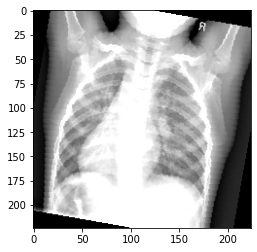

In [6]:
import matplotlib.pyplot as plt
plt.imshow(tensor_image)

# 2 Redes convolucionales profundas

In [7]:
#1 
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(2020)


class DWSepConv2d(nn.Module):
    
    def __init__(self,in_channels, out_channels, kernel_size,padding,bias=True):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels,kernel_size,padding=padding,bias=bias)
        self.conv2 = nn.Conv2d(out_channels, out_channels,kernel_size=1,padding=padding,bias=bias)
    def forward(self,xb):
        xb = F.relu(self.conv1(xb.float()))
        xb = F.relu(self.conv2(xb)) 
        return xb

In [8]:
#2

class VGG16DWSep(nn.Module):
    
    def __init__(self,in_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels,64,kernel_size=3,padding=1,stride=1)
        self.conv2 = nn.Conv2d(64,64,kernel_size=3, padding=1, stride=1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2,stride=2) # verificar los tamaños
        self.dwconv3 = DWSepConv2d(64,128,kernel_size=3,padding=1)
        self.dwconv4 = DWSepConv2d(128,128,kernel_size=3,padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.dwconv5 = DWSepConv2d(128,256,kernel_size=3,padding=1)
        self.batchnorm1 = nn.BatchNorm2d(256)
        self.dwconv6 = DWSepConv2d(256,256,kernel_size=3,padding=1)
        self.batchnorm2 = nn.BatchNorm2d(256)
        self.dwconv7 = DWSepConv2d(256,256,kernel_size=3,padding=1)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.dwconv8 = DWSepConv2d(256,512,kernel_size=3,padding=1)
        self.batchnorm3 = nn.BatchNorm2d(512)
        self.dwconv9 = DWSepConv2d(512,512,kernel_size=3,padding=1)
        self.batchnorm4 = nn.BatchNorm2d(512)
        self.dwconv10 = DWSepConv2d(512,512,kernel_size=3,padding=1)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.flatten1 = nn.Flatten()
        self.lin1 = nn.Linear(512,1024)
        self.drop1 = nn.Dropout(.7)
        self.lin2 = nn.Linear(1024,512)
        self.drop2 = nn.Dropout(.5)
        self.lin3 = nn.Linear(512,2)
    
    def forward(self,xb):
        xb = xb.view(-1,3,224,224).float()
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.maxpool1(xb))
        xb = F.relu(self.dwconv3(xb))
        xb = F.relu(self.dwconv4(xb))
        xb = F.relu(self.maxpool2(xb))
        xb = F.relu(self.dwconv5(xb))
        xb = F.relu(self.batchnorm1(xb))
        xb = F.relu(self.dwconv6(xb))
        xb = F.relu(self.batchnorm2(xb))
        xb = F.relu(self.dwconv7(xb))
        xb = F.relu(self.maxpool3(xb))
        xb = F.relu(self.dwconv8(xb))
        xb = F.relu(self.batchnorm3(xb))
        xb = F.relu(self.dwconv9(xb))
        xb = F.relu(self.mbatchnorm4(xb))
        xb = F.relu(self.dwconv10(xb))
        xb = F.relu(self.flatten1(xb))
        xb = F.relu(self.lin1(xb))
        xb = F.relu(self.drop1(xb))
        xb = F.relu(self.lin2(xb))
        xb = F.relu(self.drop2(xb))
        xb = F.relu(self.lin3(xb))
        
        
        

In [17]:
# Descargamos la red vgg16
vgg16 = torchvision.models.vgg16(pretrained=True, progress=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


In [9]:

import os
try:
    from urllib.request import URLopener
except ImportError:
    from urllib import URLopener

# Download VGG-16 weights from PyTorch
vgg_url = 'https://download.pytorch.org/models/vgg16_bn-6c64b313.pth'
if not os.path.isfile('./vgg16_bn-6c64b313.pth'):
    weights = URLopener().retrieve(vgg_url, './vgg16_bn-6c64b313.pth')

vgg16_weights = torch.load('./vgg16_bn-6c64b313.pth')

In [18]:
from torchsummary import summary
summary(vgg16.cuda(),(3,224,244))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 244]           1,792
              ReLU-2         [-1, 64, 224, 244]               0
            Conv2d-3         [-1, 64, 224, 244]          36,928
              ReLU-4         [-1, 64, 224, 244]               0
         MaxPool2d-5         [-1, 64, 112, 122]               0
            Conv2d-6        [-1, 128, 112, 122]          73,856
              ReLU-7        [-1, 128, 112, 122]               0
            Conv2d-8        [-1, 128, 112, 122]         147,584
              ReLU-9        [-1, 128, 112, 122]               0
        MaxPool2d-10          [-1, 128, 56, 61]               0
           Conv2d-11          [-1, 256, 56, 61]         295,168
             ReLU-12          [-1, 256, 56, 61]               0
           Conv2d-13          [-1, 256, 56, 61]         590,080
             ReLU-14          [-1, 256,

In [113]:
# Se deben obtener las dos primeras capas de convolucion de la red VGG16
for i in range(3):
  print(vgg16.features[i])

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [19]:
vgg16.state_dict

<bound method Module.state_dict of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size

In [20]:
# Se quiere la capa 0 y la 2, que son las dos primeras convolucionales:
pesos_dict = {
    'conv1' : vgg16.features[0],
    'conv2' : vgg16.features[2]
}

In [21]:
net = VGG16DWSep(in_channels = 3)

In [24]:
#intento de traspaso de pesos:
net.conv1 = pesos_dict['conv1']
net.conv2 = pesos_dict['conv2']

In [26]:
# Congelamos los pesos de la red vgg16
for param in vgg16.parameters():
  param.requires_grad = False

In [27]:
# Congelamos los pesos de las dos primeras capas convoluvionales de la red 
# (capas que se transfirieron):
net.conv1.requires_grad_ = False
net.conv2.requires_grad_ = False

In [29]:
net.cuda()

VGG16DWSep(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dwconv3): DWSepConv2d(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
  )
  (dwconv4): DWSepConv2d(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
  )
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dwconv5): DWSepConv2d(
    (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
  )
  (batchnorm1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_runni

In [69]:
# Clase EarlyStopping
class EarlyStopping():
  '''
  Regularization heuristic:

  '''
  def __init__(self, modo='min', paciencia=5, porcentaje=False, tol=0):
    '''
    Arguments:
    ---------
    modo: 'min' o 'max'. Si se debe minimizar o maximizar la metrica objetivo
    paciancia: Cantidad de epocas en la que la metrica puede empeorar
    porcentaje: si la diferencia es relativa (true) o absoluta
    tol: diferencia minima que debe existir con respecto la mejor metrica ya
        observada  para considerar si existe un empeoramiento del desempeno
    '''
    self.modo = modo
    self.paciencia  = paciencia
    self.porcentaje = porcentaje
    self.mejor = 10e5 if self.modo == 'min' else -10e5
    self.contador_epocas = 0

  
  def compareMin(self, metrica_validacion):
    if self.porcentaje:
      # si rel_dif > 0, es peor que el anterior
      rel_dif = (metrica_validacion - self.mejor)/self.mejor
      # Si la dif relativa es mayor a la tolerada: actualizar contador_epocas:
      if rel_dif > self.tol:
        self.contador_epocas += 1
        return False
      else:
        return True

  # Es necesaria la anotacion??
  #@classmethod
  def mejor(self, metrica_validacion):
    '''
    Compara @metrica_validacion con la mejor ya observada segun las 
    especificaciones de porcentaje y modo. 

    Si @metrica_validacion es mejor a la anterior, se guarda como la mejor 
    y se reinicia el contador de epocas. 
    Sino, se suma 1 a las epocas en que la metrica a empeorado. 
    '''
    if self.modo == 'min':
      # Comparar segun el modo y porcentaje:
      if compareMin(metrica_validacion):
        self.mejor = metrica_validacion
        return True
      else:
        return False




In [67]:
es = EarlyStopping(modo = 'max')

In [68]:
es.mejor

-1000000.0